# Churn Prediction in Telecom Industry

If you have a look at the European Business review statistics, it is mindblowing that telecommunication providers lose almost $65 million a month from customer churn which is way tooo expensive. It also contributes to one of the biggest problem in the industry.

This project tries to predict churn in the telecom industry.

## Importing libraries and packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='white')

import xgboost as xgb
from xgboost import DMatrix

import lightgbm as lgb

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score, fbeta_score, f1_score, classification_report
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, LabelEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.feature_selection import chi2, SelectKBest, f_classif
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import category_encoders as ce
import optuna
from optuna.integration import LightGBMPruningCallback

import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
from feature_engine.imputation import CategoricalImputer, DropMissingData
from feature_engine.encoding import RareLabelEncoder
from sklearn.metrics import make_scorer
from feature_engine.wrappers import SklearnTransformerWrapper
from catboost import CatBoostClassifier
import lightgbm as lgb
import pickle

## Loading the dataset

In [4]:
df = pd.read_csv(r'C:\Users\user\Desktop\__PYTHON__\Datasets\WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## EDA

In [5]:
df.shape

(7043, 21)

In [6]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


The TotalCharges column is an object type which is not supposed to be. I'll be converting it to a numeric type.

In [8]:
df.TotalCharges = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [9]:
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

#### Summary of the non-null columns in the dataset

In [10]:
null = df.isnull().sum().sort_values(ascending=False)
n1 = df.isnull().sum()/df.isnull().count()*100
n2 = (np.round(n1, 1)).sort_values(ascending=False)
missing_val = pd.concat([null, n2], axis=1, keys=['Total null', 'Percent(%)'])
missing_val

,Total null,Percent(%)
TotalCharges,11,0.2
customerID,0,0.0
DeviceProtection,0,0.0
MonthlyCharges,0,0.0
PaymentMethod,0,0.0
PaperlessBilling,0,0.0
Contract,0,0.0
StreamingMovies,0,0.0
StreamingTV,0,0.0
TechSupport,0,0.0


#### A quick viz of the dataset's categorical columns

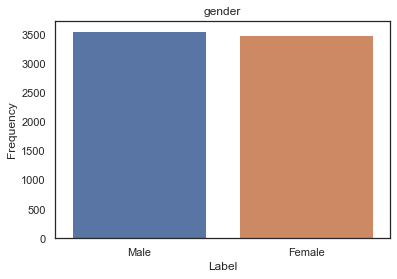

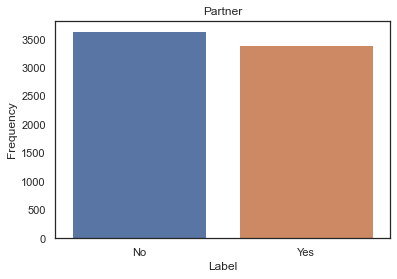

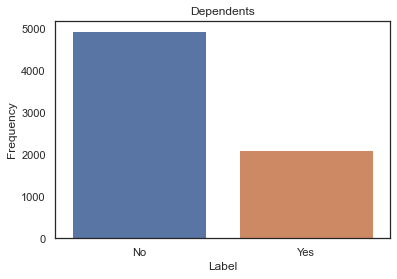

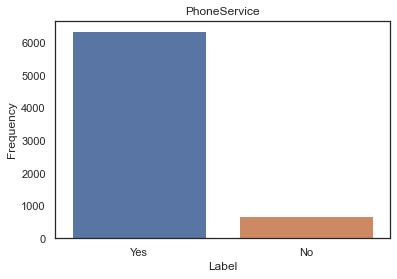

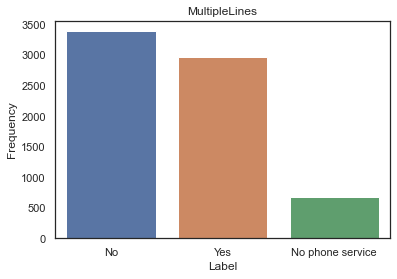

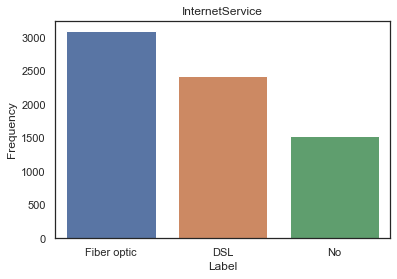

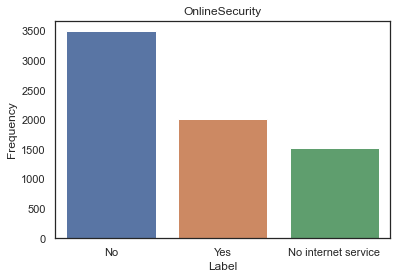

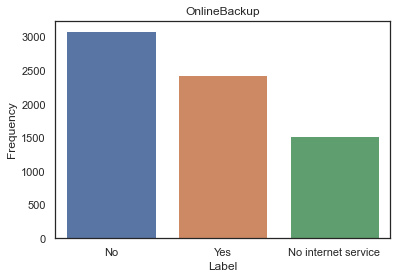

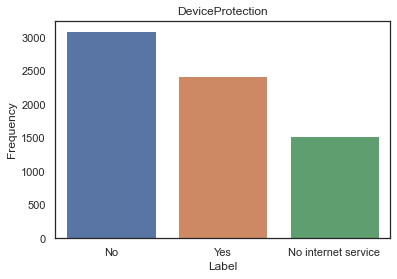

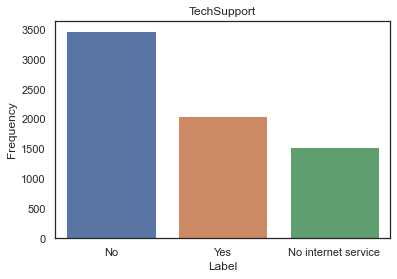

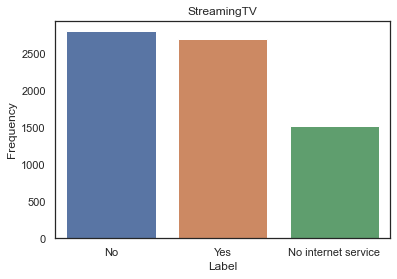

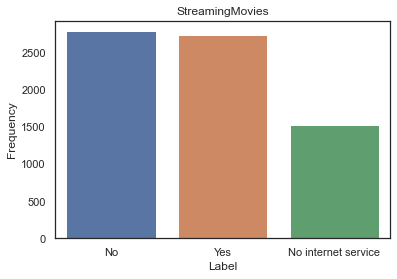

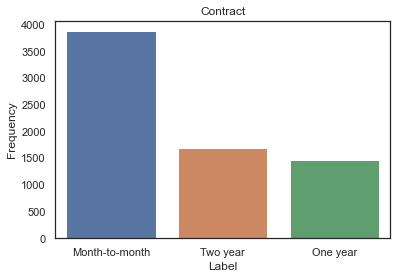

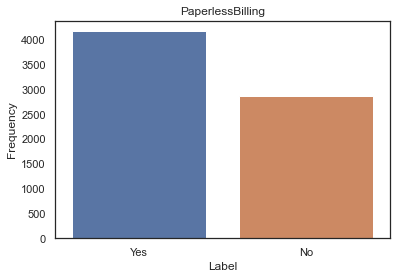

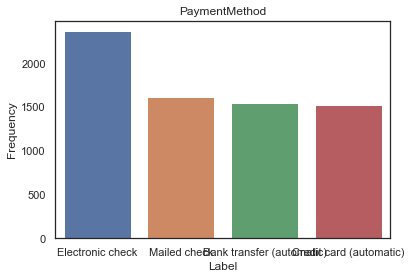

In [11]:
review = df[['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
            'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']]
for i in review.columns:
    plt.figure(figsize=(6, 4))
    sns.barplot(x=review[i].value_counts().index, y=review[i].value_counts()).set(title=i, xlabel='Label', ylabel='Frequency')
    plt.show()

## Further Analysis

### Churn

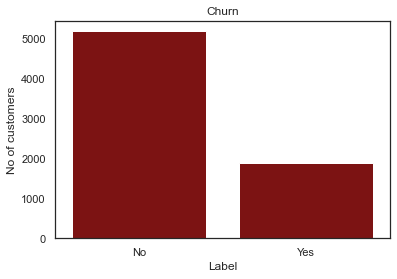

In [12]:
colors = ['#8e0201', '#e8cccc']
sns.countplot(x=df['Churn'], color=colors[0])
plt.title('Churn')
plt.xlabel('Label')
plt.ylabel('No of customers')
plt.show();

Majority of customers experienced a negative churn

#### Churn based on Gender

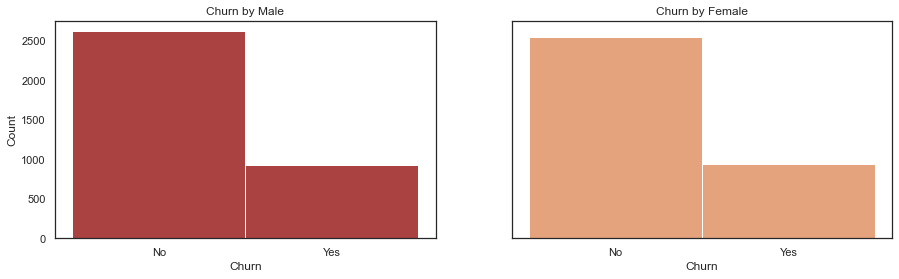

In [13]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, sharey = True, figsize=(15,4))

ax = sns.histplot(df[df['gender']=='Male']['Churn'], kde=False, color='#8e0201', ax=ax1)
ax.set_title('Churn by Male')
ax = sns.histplot(df[df['gender']=='Female']['Churn'], kde=False, color=sns.color_palette()[1], ax=ax2)
ax.set_title('Churn by Female');

### Gender

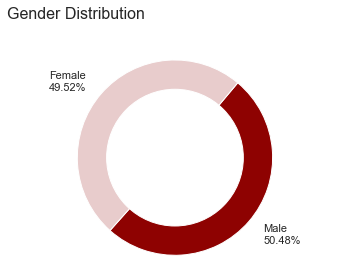

In [14]:
counts = df['gender'].value_counts()
fig, ax = plt.subplots()
colors = ['#8e0201', '#e8cccc']
label = ['Male\n50.48%', 'Female\n49.52%']
ax.pie(counts, labels=label, colors=colors, startangle=50, counterclock=False, pctdistance=0.8, labeldistance=1.2)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)
ax.set_title('Gender Distribution', fontsize = 16, loc='left', pad=30)
ax.axis('equal')
plt.show();

From the above, the majority of the customers is seen to be Male. 

### Partner

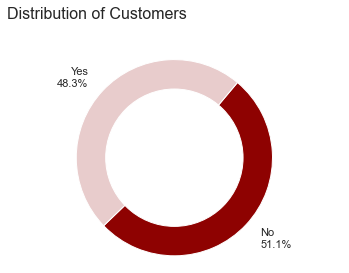

In [15]:
counts = df['Partner'].value_counts()
fig, ax = plt.subplots()
colors = ['#8e0201', '#e8cccc']
label = ['No\n51.1%', 'Yes\n48.3%']
ax.pie(counts, labels=label, colors=colors, startangle=50, counterclock=False, pctdistance=0.8, labeldistance=1.2)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)
ax.set_title('Distribution of Customers', fontsize = 16, loc='left', pad=30)
ax.axis('equal')
plt.show();

Majority of the customers have no partners. (51.7%)

### Senior Citizen

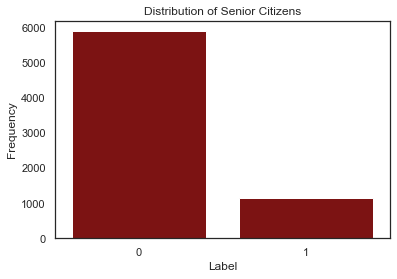

In [16]:
colors = ['#8e0201', '#e8cccc']
sns.countplot(data=df, x='SeniorCitizen', color=colors[0]).set(title='Distribution of Senior Citizens', xlabel='Label', ylabel='Frequency')
plt.show();

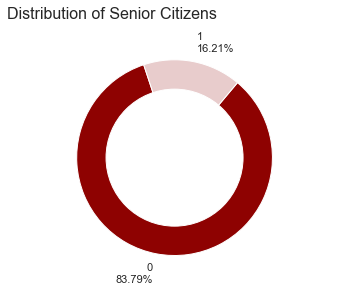

In [17]:
counts = df['SeniorCitizen'].value_counts()
fig, ax = plt.subplots()
colors = ['#8e0201', '#e8cccc']
label = ['0\n83.79%', '1\n16.21%']
ax.pie(counts, labels=label, colors=colors, startangle=50, counterclock=False, pctdistance=0.8, labeldistance=1.2)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)
ax.set_title('Distribution of Senior Citizens', fontsize = 16, loc='left', pad=30)
ax.axis('equal')
plt.show();

16.21% (1142) of the customers were younger citizens while 83.79% (5901) were Senior Citizens

### Dependents

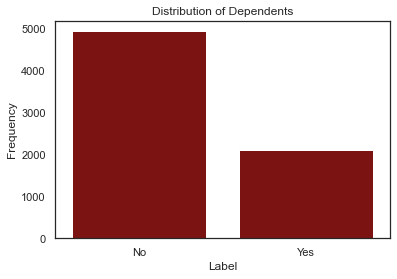

In [18]:
colors = ['#8e0201', '#e8cccc']
sns.countplot(data=df, x='Dependents', color=colors[0]).set(title='Distribution of Dependents', xlabel='Label', ylabel='Frequency')
plt.show();

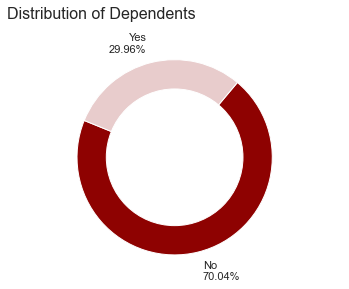

In [19]:
counts = df['Dependents'].value_counts()
fig, ax = plt.subplots()
colors = ['#8e0201', '#e8cccc']
label = ['No\n70.04%', 'Yes\n29.96%']
ax.pie(counts, labels=label, colors=colors, startangle=50, counterclock=False, pctdistance=0.8, labeldistance=1.2)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)
ax.set_title('Distribution of Dependents', fontsize = 16, loc='left', pad=30)
ax.axis('equal')
plt.show();

Few of the customers actually have dependents

### Customer Services

In [20]:
def get_colors(num_wedges):
    if num_wedges == 2:
        return ['#8e0201', '#c93432']  # Two colors
    elif num_wedges == 3:
        return ['#8e0201', '#c93432', '#e8cccc']  # Three colors
    elif num_wedges == 4:
        return ['#8e0201', '#c93432', '#e8cccc', '#e8cccc']  # Four colors
    else:
        # Handle cases with more than four wedges (add more colors as needed)
        return ['#FFC107', '#2196F3', '#4CAF50', '#FF5722', '#9C27B0', '#00BCD4', '#FFEB3B', '#795548']

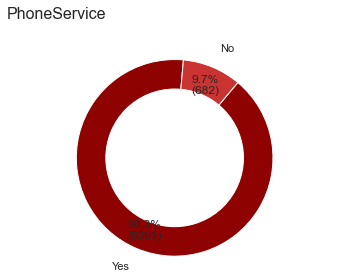

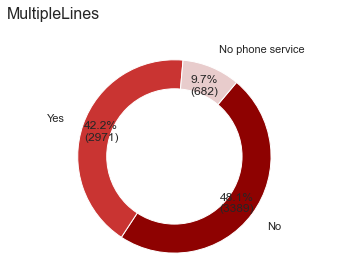

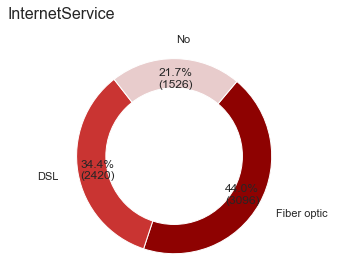

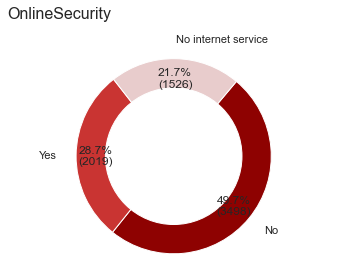

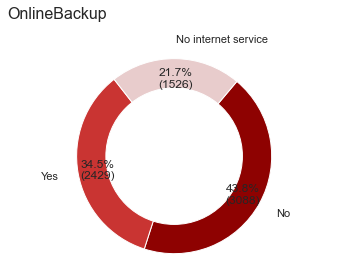

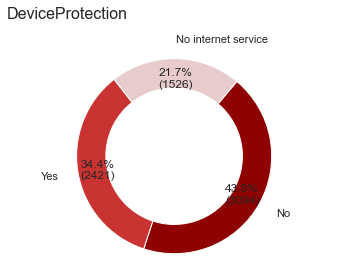

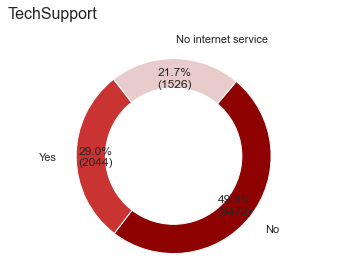

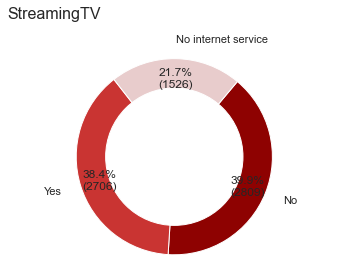

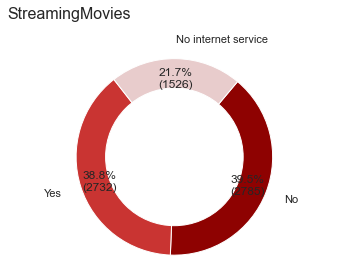

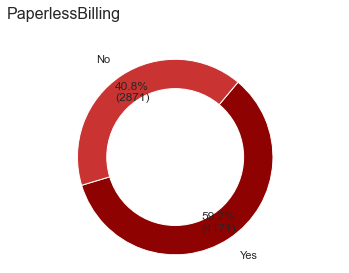

In [21]:
def func(pct, allvalues):
    abs = int(pct/100.*np.sum(allvalues))
    return '{:.1f}%\n({:d})'.format(pct, abs)

review = df[['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
            'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling']]
for i in review.columns:
    fig, ax = plt.subplots()
    num_wedges = len(review[i].value_counts())
    colors = get_colors(num_wedges)
    ax.pie(x=review[i].value_counts(), labels=review[i].value_counts().index, colors=colors, startangle=50, counterclock=False, 
           pctdistance=0.8, labeldistance=1.2, autopct=lambda pct: func(pct, review[i].value_counts().values))
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig.gca().add_artist(centre_circle)
    ax.set_title(i, fontsize = 16, loc='left', pad=30)
    ax.axis('equal')
    plt.show()

### Contract

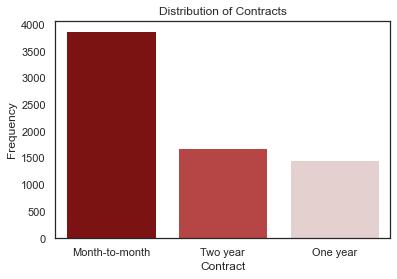

In [22]:
colors = ['#8e0201', '#c93432', '#e8cccc']
palette = sns.set_palette(sns.color_palette(colors))
order = df.Contract.value_counts().index
sns.countplot(data=df, x='Contract', order=order, palette=palette).set(title='Distribution of Contracts',
                                                                        xlabel='Contract', ylabel='Frequency')
plt.show();

The `Month-to-month` is the contractual situation of most customers

#### Contract based on Tenure

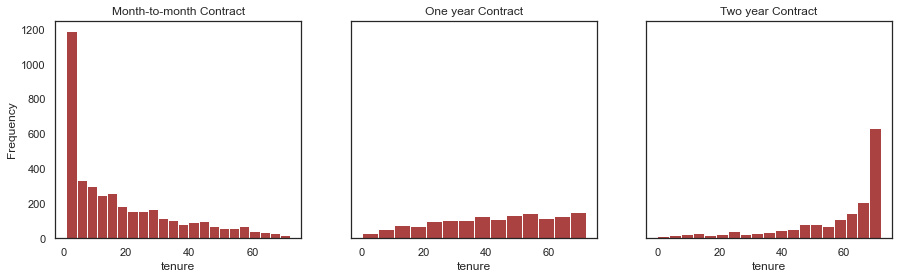

In [23]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, sharey = True, figsize=(15,4))

ax = sns.histplot(df[df['Contract']=='Month-to-month']['tenure'], kde=False, color = '#8e0201', ax=ax1)
ax.set_ylabel('Frequency')
ax.set_title('Month-to-month Contract')
ax = sns.histplot(df[df['Contract']=='One year']['tenure'], kde=False, color = '#8e0201', ax=ax2)
ax.set_ylabel('Frequency')
ax.set_title('One year Contract')
ax = sns.histplot(df[df['Contract']=='Two year']['tenure'], kde=False, color = '#8e0201', ax=ax3)
ax.set_ylabel('Frequency')
ax.set_title('Two year Contract')
plt.show();

#### Contract based on Churn

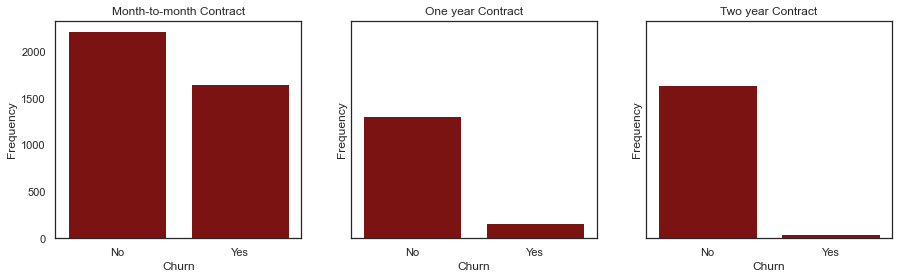

In [24]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, sharey = True, figsize=(15,4))

ax = sns.countplot(x=df[df['Contract']=='Month-to-month']['Churn'], color='#8e0201', ax=ax1)
ax.set_ylabel('Frequency')
ax.set_title('Month-to-month Contract')
ax = sns.countplot(x=df[df['Contract']=='One year']['Churn'], color='#8e0201', ax=ax2)
ax.set_ylabel('Frequency')
ax.set_title('One year Contract')
ax = sns.countplot(x=df[df['Contract']=='Two year']['Churn'], color='#8e0201', ax=ax3)
ax.set_ylabel('Frequency')
ax.set_title('Two year Contract')
plt.show();

#### Contract based on Gender

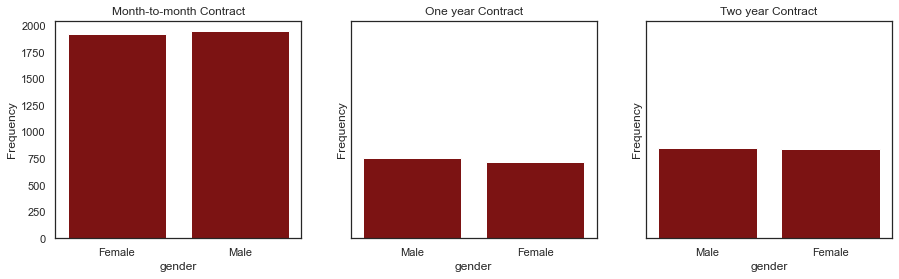

In [25]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, sharey = True, figsize=(15,4))

ax = sns.countplot(x=df[df['Contract']=='Month-to-month']['gender'], color='#8e0201', ax=ax1)
ax.set_ylabel('Frequency')
ax.set_title('Month-to-month Contract')
ax = sns.countplot(x=df[df['Contract']=='One year']['gender'], color='#8e0201', ax=ax2)
ax.set_ylabel('Frequency')
ax.set_title('One year Contract')
ax = sns.countplot(x=df[df['Contract']=='Two year']['gender'], color='#8e0201', ax=ax3)
ax.set_ylabel('Frequency')
ax.set_title('Two year Contract')
plt.show();

### Charges

The charges consists of the Monthly Charges and the Total Charges

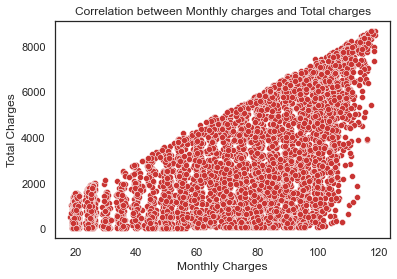

In [26]:
sns.scatterplot(x=df['MonthlyCharges'], y=df['TotalCharges'], color='#c93432')
plt.title('Correlation between Monthly charges and Total charges')
plt.xlabel('Monthly Charges')
plt.ylabel('Total Charges')
plt.show();

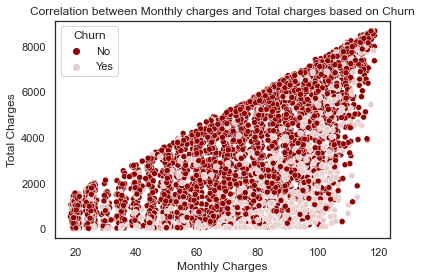

In [27]:
colors = ['#8e0201', '#e8cccc']
palette = sns.set_palette(sns.color_palette(colors))
sns.scatterplot(data=df, x='MonthlyCharges', y='TotalCharges', hue='Churn', palette=palette)
plt.title('Correlation between Monthly charges and Total charges based on Churn')
plt.xlabel('Monthly Charges')
plt.ylabel('Total Charges')
plt.show();

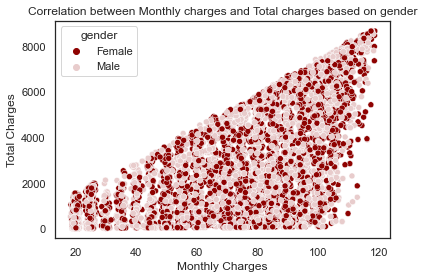

In [28]:
colors = ['#8e0201', '#e8cccc']
palette = sns.set_palette(sns.color_palette(colors))
sns.scatterplot(data=df, x='MonthlyCharges', y='TotalCharges', hue='gender', palette=palette)
plt.title('Correlation between Monthly charges and Total charges based on gender')
plt.xlabel('Monthly Charges')
plt.ylabel('Total Charges')
plt.show();

### Payment Methods

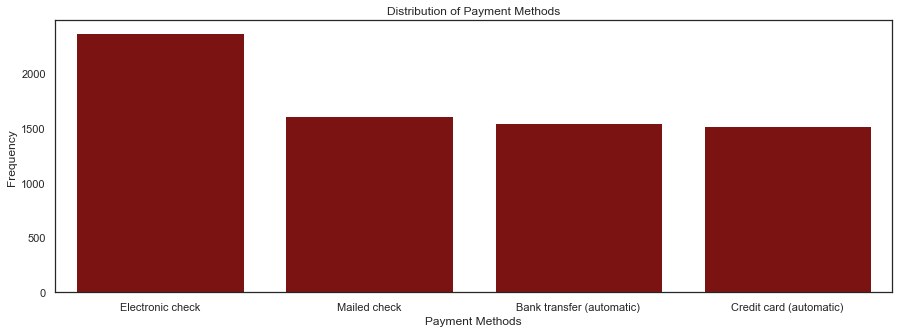

In [29]:
plt.figure(figsize=(15, 5))
sns.countplot(data=df, x='PaymentMethod', color='#8e0201')
plt.title('Distribution of Payment Methods')
plt.xlabel('Payment Methods')
plt.ylabel('Frequency')
plt.show();

The `electronic check` is the most common method of payment

#### Testing Numerical Features With ANOVA

In [30]:
print('The categorical features are:\n {}'.format(df.select_dtypes(include='object').columns.tolist()))
print('The numerical features are:\n {}'.format(df.select_dtypes(include='number').columns.tolist()))

The categorical features are:
 ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']
The numerical features are:
 ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


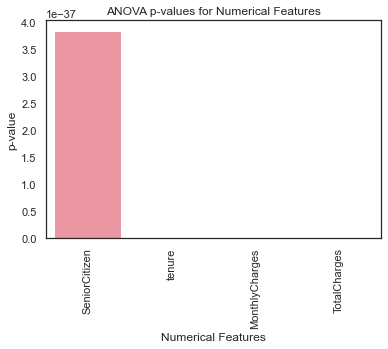

In [31]:
from scipy.stats import f_oneway

# Numerical features
numerical_features = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

# Perform ANOVA and calculate p-value for each numerical feature
p_values = {}
for feature in numerical_features:
    groups = df.groupby('Churn')[feature].apply(list)
    f_value, p_value = f_oneway(*groups)
    p_values[feature] = p_value

# Visualize the p-values among the numerical features
sns.barplot(x=list(p_values.keys()), y=list(p_values.values()))
plt.xticks(rotation=90)
plt.xlabel('Numerical Features')
plt.ylabel('p-value')
plt.title('ANOVA p-values for Numerical Features')
plt.show()

In [32]:
# remove columns with high p-values from ANOVA test
# anova_drop = ['SeniorCitizen']
# df = df.drop(anova_drop, axis=1)

## Model Training

### Creating Training and Testing Sets

In [33]:
# get input and output data
X = df.drop(['Churn', 'customerID'], axis=1)
y = df['Churn']

In [36]:
warnings.filterwarnings('ignore')

# Converting categorical variables to numeric data
cat_pipeline = Pipeline(
    steps=[('impute', SimpleImputer(strategy='most_frequent')),
        ('one-hot encoding', OneHotEncoder(handle_unknown='ignore'))
        # ('target encoding', ce.TargetEncoder())
    ]
)

# Scaling numerical features and filling missing values
num_pipeline = Pipeline(
    steps=[('impute', SimpleImputer(strategy='mean')),
          ('scale', StandardScaler())]
)

# Numerical and categorical feature names
cat_cols = X.select_dtypes(exclude='number').columns
num_cols = X.select_dtypes(include='number').columns
print('Categorical columns:\n', cat_cols);print()
print('Numeric columns:\n',num_cols)

# Combining the two pipelines with a column transformer
from sklearn.compose import ColumnTransformer
full_pipeline = ColumnTransformer(
    transformers=[
        ('numeric', num_pipeline, num_cols),
        ('categorical', cat_pipeline, cat_cols)
    ]
)

# encode the target label
le = LabelEncoder()
y = le.fit_transform(y)

# get mapping for each label
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print('\n', le_name_mapping)

# Fitting the pipeline
X_ = full_pipeline.fit_transform(X, y)

# Retrieve column names after applying ColumnTransformer
cat_encoder = full_pipeline.named_transformers_['categorical']
cat_feature_names = cat_encoder.named_steps['one-hot encoding'].get_feature_names(cat_cols)
feature_names = list(num_cols) + list(cat_feature_names)

# Create DataFrames with correct column names
X_df = pd.DataFrame(X_, columns=feature_names)
y_df = y

Categorical columns:
 Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')

Numeric columns:
 Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')

 {'No': 0, 'Yes': 1}


### Baseline Models

In [37]:
X_train, X_test, y_train, y_test= train_test_split(X_df, y_df, stratify=y_df, random_state=101, test_size=0.3)

In [38]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4930, 45) (4930,)
(2113, 45) (2113,)


In [39]:
# train a dummy classifier
dummy_clf = DummyClassifier(strategy="uniform", random_state=42)
dummy_clf.fit(X_train, y_train)

# generate predictions
y_pred_dummy = dummy_clf.predict(X_test)

In [40]:
# Define final pipeline with preprocessing and logistic regression model
pipeline_log = Pipeline([
    # ('full_pipeline', full_pipeline),
    ('logistic_regression', LogisticRegression())
])

# Fit the data and generate predictions
pipeline_log.fit(X_train, y_train)
y_pred_log = pipeline_log.predict(X_test)

In [41]:
# derive the f2-scores for each baseline model
f2_score_dummy = fbeta_score(y_test, y_pred_dummy, average='micro', beta=2)
f2_score_log = fbeta_score(y_test, y_pred_log, average='micro', beta=2)

# print the f-2 score
print(f'F2 score of dummy classifier: {f2_score_dummy}')
print(f'F2 score of logistic regression classifier: {f2_score_log}')

F2 score of dummy classifier: 0.514907714150497
F2 score of logistic regression classifier: 0.7983909133932797


## LightGBM

In [42]:
def objective(trial):
    warnings.filterwarnings('ignore')

    # Define parameters to tune with Optuna
    params_lgb = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 20),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.001, 0.1),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
    }

    # Initialize the LightGBM classifier
    lgb_model = lgb.LGBMClassifier(**params_lgb, objective='binary', metric='auc', random_state=101)

    # Perform stratified split and transform the input data
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=101)
    auc_roc_scores = []

    for train_idx, val_idx in skf.split(X_df, y_df):
        X_train, X_val = X_df.iloc[train_idx], X_df.iloc[val_idx]
        y_train, y_val = y_df[train_idx], y_df[val_idx]

        # Fit the model and generate predictions
        lgb_model.fit(X_train, y_train,
                      early_stopping_rounds=50,
                      eval_set=[(X_val, y_val)],
                      verbose=False)

        y_pred_prob = lgb_model.predict_proba(X_val)

        # Calculate AUC-ROC score and add it to the list
        auc_roc_scores.append(roc_auc_score(y_val, y_pred_prob[:, 1]))

    # Return the mean of AUC-ROC scores
    return np.mean(auc_roc_scores)

# Create an Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Get the best parameters and best score
best_params_lgb = study.best_params
best_score_lgb = study.best_value

print("Best parameters:", best_params_lgb)
print("Best score (mean AUC-ROC):", best_score_lgb)

[I 2023-06-12 12:57:01,410] A new study created in memory with name: no-name-363b0c2d-3e5d-4f8c-b26d-4a28d6586936
[I 2023-06-12 12:57:06,049] Trial 0 finished with value: 0.8472762105961964 and parameters: {'n_estimators': 121, 'max_depth': 7, 'min_child_samples': 11, 'subsample': 0.5440149409304489, 'colsample_bytree': 0.6869449331739916, 'learning_rate': 0.08008114212154967, 'num_leaves': 248}. Best is trial 0 with value: 0.8472762105961964.
[I 2023-06-12 12:57:10,915] Trial 1 finished with value: 0.8433695388885436 and parameters: {'n_estimators': 110, 'max_depth': 7, 'min_child_samples': 4, 'subsample': 0.802708684136128, 'colsample_bytree': 0.8212729793960108, 'learning_rate': 0.09402577133617525, 'num_leaves': 164}. Best is trial 0 with value: 0.8472762105961964.
[I 2023-06-12 12:57:18,784] Trial 2 finished with value: 0.8491499964302294 and parameters: {'n_estimators': 130, 'max_depth': 9, 'min_child_samples': 19, 'subsample': 0.6199550238507241, 'colsample_bytree': 0.5809650799

Best parameters: {'n_estimators': 123, 'max_depth': 4, 'min_child_samples': 1, 'subsample': 0.8221480933054767, 'colsample_bytree': 0.5827141748247198, 'learning_rate': 0.04560666754206261, 'num_leaves': 189}
Best score (mean AUC-ROC): 0.8522773201915292


In [48]:
# Create an LightGBM classifier
lgb_model = lgb.LGBMClassifier(**best_params_lgb, objective='binary', metric='auc', random_state=101)

# Fit the model
lgb_model.fit(X_train, y_train,
              early_stopping_rounds=50,
              eval_set=[(X_test, y_test)],
              verbose=False)

# Generate predictions
y_pred_lgb = lgb_model.predict(X_test)

# Calculate ROC-AUC
roc_auc_lgb = roc_auc_score(y_test, y_pred_lgb)
print("ROC-AUC Score:", roc_auc_lgb)

# Calculate precision
precision_lgb = precision_score(y_test, y_pred_lgb)
print("Precision Score:", precision_lgb)

# Calculate recall
recall_lgb = recall_score(y_test, y_pred_lgb)
print("Recall Score:", recall_lgb)

# Calculate f1score
f1score_lgb = f1_score(y_test, y_pred_lgb)
print("F1 Score:", f1score_lgb)

# Calculate f2 score
f2_score_lgb = fbeta_score(y_pred_lgb, y_test, beta=2, average='micro')
print(f"F2 score of XGBoost Classifier: {f2_score_lgb}.")

# Calculate accuracy score
accuracy_score_lgb = accuracy_score(y_test, y_pred_lgb)
print("Accuracy Score:", accuracy_score_lgb)

# classification report
class_report_lgb = classification_report(y_test, y_pred_lgb)
print('\nClassification report: \n\n{}'.format(class_report_lgb))

ROC-AUC Score: 0.7097236387525958
Precision Score: 0.6674418604651163
Recall Score: 0.5115864527629234
F1 Score: 0.579212916246216
F2 score of XGBoost Classifier: 0.8026502602934217.
Accuracy Score: 0.8026502602934217

Classification report: 

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1552
           1       0.67      0.51      0.58       561

    accuracy                           0.80      2113
   macro avg       0.75      0.71      0.73      2113
weighted avg       0.79      0.80      0.79      2113



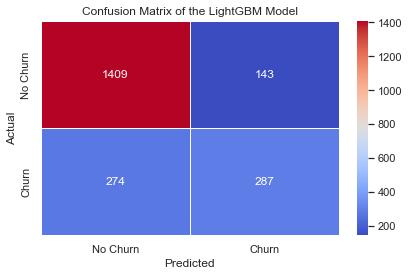

In [44]:
cm_lgb = confusion_matrix(y_test, y_pred_lgb)
labels = ['No Churn', 'Churn']
cm_df_lgb = pd.DataFrame(cm_lgb, index=labels, columns=labels)
fig, ax = plt.subplots()
sns.heatmap(cm_df_lgb, annot=True, fmt='d', cmap='coolwarm', cbar=True, linewidths=0.5, ax=ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix of the LightGBM Model')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.tight_layout()
plt.show()

## XGBOOST

In [49]:
def objective(trial):
    warnings.filterwarnings('ignore')

    # Define parameters to tune with Optuna
    params_xgb = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10)
    }

    # Initialize the XGBoost classifier
    xgb_model = xgb.XGBClassifier(**params_xgb, objective='binary:logistic', eval_metric='auc', random_state=101)

    # Perform stratified split and transform the input data
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=101)
    auc_roc_scores = []

    for train_idx, val_idx in skf.split(X_df, y_df):
        X_train, X_val = X_df.iloc[train_idx], X_df.iloc[val_idx]
        y_train, y_val = y_df[train_idx], y_df[val_idx]

        # Fit the model and generate predictions
        xgb_model.fit(X_train, y_train,
                      early_stopping_rounds=50,
                      eval_set=[(X_val, y_val)],
                      verbose=False)

        y_pred_prob = xgb_model.predict_proba(X_val)

        # Calculate AUC-ROC score and add it to the list
        auc_roc_scores.append(roc_auc_score(y_val, y_pred_prob[:, 1]))

    # Return the mean of AUC-ROC scores
    return np.mean(auc_roc_scores)

# Create an Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Get the best parameters and best score
best_params_xgb = study.best_params
best_score_xgb = study.best_value

print("Best parameters:", best_params_xgb)
print("Best score (mean AUC-ROC):", best_score_xgb)

[I 2023-06-12 13:24:16,890] A new study created in memory with name: no-name-438a52df-79ab-4a0d-b834-f093394e7427
[I 2023-06-12 13:25:08,957] Trial 0 finished with value: 0.8482827056335822 and parameters: {'n_estimators': 660, 'max_depth': 9, 'learning_rate': 0.012320707269230543, 'subsample': 0.8542606143074398, 'colsample_bytree': 0.5669131785138688, 'gamma': 2.454506535990781, 'min_child_weight': 8.44277426525781, 'reg_alpha': 9.755070938785146, 'reg_lambda': 6.794120778641651}. Best is trial 0 with value: 0.8482827056335822.
[I 2023-06-12 13:25:36,581] Trial 1 finished with value: 0.8524054969128356 and parameters: {'n_estimators': 922, 'max_depth': 5, 'learning_rate': 0.04783509821780285, 'subsample': 0.6845767939881431, 'colsample_bytree': 0.9180103293729786, 'gamma': 2.1634502050930955, 'min_child_weight': 5.368374918088594, 'reg_alpha': 1.9572457635615093, 'reg_lambda': 4.450487196631555}. Best is trial 1 with value: 0.8524054969128356.
[I 2023-06-12 13:25:56,659] Trial 2 fini

Best parameters: {'n_estimators': 960, 'max_depth': 4, 'learning_rate': 0.08071845950117598, 'subsample': 0.7364402830564084, 'colsample_bytree': 0.89062172028737, 'gamma': 3.546053800149575, 'min_child_weight': 1.8785931770948852, 'reg_alpha': 1.1954932338763664, 'reg_lambda': 1.8593968688984774}
Best score (mean AUC-ROC): 0.8536893812019611


In [50]:
# Create an XGBOOST classifier
xgb_model = xgb.XGBClassifier(**best_params_xgb, objective='binary:logistic', eval_metric='auc', random_state=101)

# Fit the model
xgb_model.fit(X_train, y_train,
              early_stopping_rounds=50,
              eval_set=[(X_test, y_test)],
              verbose=False)

# Generate predictions
y_pred_xgb = xgb_model.predict(X_test)

# Calculate ROC-AUC
roc_auc_xgb = roc_auc_score(y_test, y_pred_xgb)
print("ROC-AUC Score:", roc_auc_xgb)

# Calculate precision
precision_xgb = precision_score(y_test, y_pred_xgb)
print("Precision Score:", precision_xgb)

# Calculate recall
recall_xgb = recall_score(y_test, y_pred_xgb)
print("Recall Score:", recall_xgb)

# Calculate f1score
f1score_xgb = f1_score(y_test, y_pred_xgb)
print("F1 Score:", f1score_xgb)

# Calculate f2 score
f2_score_xgb = fbeta_score(y_pred_xgb, y_test, beta=2, average='micro')
print(f"F2 score of XGBoost Classifier: {f2_score_xgb}.")

# Calculate accuracy score
accuracy_score_xgb = accuracy_score(y_test, y_pred_xgb)
print("Accuracy Score:", accuracy_score_xgb)

# classification report
class_report_xgb = classification_report(y_test, y_pred_xgb)
print('\nClassification report: \n\n{}'.format(class_report_xgb))

ROC-AUC Score: 0.7215782751713619
Precision Score: 0.6616052060737527
Recall Score: 0.5436720142602496
F1 Score: 0.5968688845401174
F2 score of XGBoost Classifier: 0.8050165641268339.
Accuracy Score: 0.8050165641268339

Classification report: 

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1552
           1       0.66      0.54      0.60       561

    accuracy                           0.81      2113
   macro avg       0.75      0.72      0.73      2113
weighted avg       0.80      0.81      0.80      2113



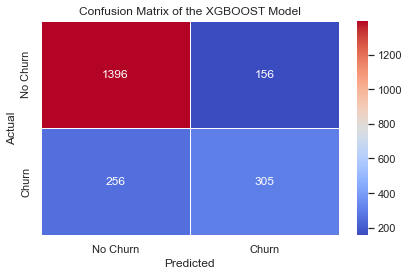

In [52]:
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
labels = ['No Churn', 'Churn']
cm_df_xgb = pd.DataFrame(cm_xgb, index=labels, columns=labels)
fig, ax = plt.subplots()
sns.heatmap(cm_df_xgb, annot=True, fmt='d', cmap='coolwarm', cbar=True, linewidths=0.5, ax=ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix of the XGBOOST Model')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.tight_layout()
plt.show()

The confusion matrix is a table that summarizes the performance of a classification model. It shows the counts of true positive (TP), true negative (TN), false positive (FP), and false negative (FN) predictions. In this case, the confusion matrix represents a binary classification problem for predicting customer churn in the telecom industry.

Interpreting the values in the confusion matrix:

- True Positives (TP): There are 256 instances that were correctly predicted as "Churn" (positive class).
- True Negatives (TN): There are 1396 instances that were correctly predicted as "No Churn" (negative class).
- False Positives (FP): There are 156 instances that were incorrectly predicted as "Churn" when the actual label was "No Churn".
- False Negatives (FN): There are 256 instances that were incorrectly predicted as "No Churn" when the actual label was "Churn". <br>

By analyzing these values, I have been able to gain insights into the performance of the churn prediction model. For example, the number of false positives (156) suggests that there were instances where customers were predicted as "Churn" incorrectly. Similarly, the number of false negatives (256) indicates instances where customers who churned were predicted as "No Churn" incorrectly.

## Export trained LightGBM and XGBoost Models to a File

In [59]:
# Export the LightGBM model to a file
filename = 'lightgbm_model.pkl'
pickle.dump(lgb_model, open(filename, 'wb'))

In [61]:
# Export the XGBoost model to a file
filename = 'xgboost_model.pkl'
pickle.dump(xgb_model, open(filename, 'wb'))